# Centralized learning for ECG Arrhythmia detection


In [1]:
import configparser
import os
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import wandb
from dotenv import load_dotenv
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

from dataset_utils import Cinc2017DataModule
from model import DenseNetGruEcgModule

/home/g113056077/.pyenv/versions/awin-ecg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config


In [2]:
load_dotenv()
wandb_mode = os.getenv("WANDB_MODE")

config = configparser.ConfigParser()
config.read("config.ini")
dst_freq = config.getint("data_preprocessing", "dst_freq")
dst_time = config.getint("data_preprocessing", "dst_time")
dst_length = dst_freq * dst_time

MAX_EPOCHS = 50

## Prepare the Dataset


In [3]:
dm = Cinc2017DataModule(batch_size=64)

## Create the Model


In [4]:
model = DenseNetGruEcgModule(
    max_epochs=MAX_EPOCHS,
    num_classes=dm.num_classes,
    input_length=dst_length,
    lr_scheduler_mode="multi_step",
    lr=1e-3,
    # min_lr = 1e-4,
    show_valid_cm=True,
    growth_rate=16,
    block_config=(4, 4, 12, 8, 8, 8),
    num_init_features=64,
    bn_size=4,
    db_drop_rate=0.2,
    gru_drop_rate=0.2,
    fc_drop_rate=0.2,
    memory_efficient=False,
    compression_factor=0.5,
)

# the number of features per denseblock:
# (64 + 4 * 16) // 2 = 64
# (64 + 4 * 16) // 2 = 64
# (64 + 12 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (256 + 8 * 16) // 2 = 128

## Create the Trainer


In [5]:
checkpoint_callback = ModelCheckpoint(
    monitor="valid_auprc",
    verbose=True,
    mode="max",
    save_top_k=1,
    save_last=True,
)

# early_stopping_callback = EarlyStopping(
#     monitor="valid_loss", patience=8, verbose=True, mode="min"
# )

progress_bar_callback = TQDMProgressBar(leave=True)

project_name = "awin-ecg-centralized"
if wandb_mode == "disabled":
    logger = TensorBoardLogger(save_dir=Path("tb_logs"), name=project_name)
else:
    logger = WandbLogger(
        project=project_name, save_dir=Path("wandb_logs"), log_model=True, name=project_name
    )

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[checkpoint_callback, progress_bar_callback],
    logger=logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Train the Model


In [6]:
trainer.fit(model, datamodule=dm)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: devilhyt to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params | Mode  | In sizes     | Out sizes
-----------------------------------------------------------------------------------------------
0 | model         | DenseNetGruEcg            | 1.3 M  | train | [1, 1, 5800] | [1, 3]   
1 | loss_fn       | CrossEntropyLoss          | 0      | train | ?            | ?        
2 | train_metrics | MetricCollection          | 0      | train | ?            | ?        
3 | valid_metrics | MetricCollection          | 0      | train | ?            | ?        
4 | test_metrics  | MetricCollection          | 0      | train | ?            | ?        
5 | valid_cm      | MulticlassConfusionMatrix | 0      | train | ?            | ?        
6 | test_cm       | MulticlassConfusionMatrix | 0      | train | ?            | ?        
-----------------------------------------------------------------------------------------------
1.3 M     Trainable params
0         Non-trai

Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 0: 100%|██████████| 91/91 [00:17<00:00,  5.24it/s, v_num=zxee, lr=0.001, valid_loss=1.090, valid_acc=0.455, valid_auprc=0.474, valid_auroc=0.663, valid_f1=0.413, train_loss=1.080, train_acc=0.420, train_auprc=0.429, train_auroc=0.602, train_f1=0.421]

Epoch 0, global step 91: 'valid_auprc' reached 0.47409 (best 0.47409), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=0-step=91.ckpt' as top 1



Valid Confusion Matrix:
tensor([[336, 196, 230],
        [ 12,  66,  36],
        [ 69, 132, 161]], device='cuda:0')
Epoch 1: 100%|██████████| 91/91 [00:17<00:00,  5.23it/s, v_num=zxee, lr=0.001, valid_loss=0.845, valid_acc=0.636, valid_auprc=0.685, valid_auroc=0.831, valid_f1=0.555, train_loss=0.901, train_acc=0.556, train_auprc=0.596, train_auroc=0.745, train_f1=0.551]

Epoch 1, global step 182: 'valid_auprc' reached 0.68475 (best 0.68475), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=1-step=182.ckpt' as top 1



Valid Confusion Matrix:
tensor([[551, 109, 102],
        [  5,  98,  11],
        [ 96, 128, 138]], device='cuda:0')
Epoch 2: 100%|██████████| 91/91 [00:17<00:00,  5.22it/s, v_num=zxee, lr=0.001, valid_loss=0.506, valid_acc=0.784, valid_auprc=0.821, valid_auroc=0.907, valid_f1=0.739, train_loss=0.688, train_acc=0.696, train_auprc=0.759, train_auroc=0.861, train_f1=0.695]
Valid Confusion Matrix:
tensor([[648,  10, 104],
        [  5,  98,  11],
        [ 84,  53, 225]], device='cuda:0')


Epoch 2, global step 273: 'valid_auprc' reached 0.82079 (best 0.82079), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=2-step=273.ckpt' as top 1


Epoch 3: 100%|██████████| 91/91 [00:17<00:00,  5.21it/s, v_num=zxee, lr=0.001, valid_loss=0.529, valid_acc=0.775, valid_auprc=0.810, valid_auroc=0.899, valid_f1=0.731, train_loss=0.582, train_acc=0.747, train_auprc=0.817, train_auroc=0.898, train_f1=0.746]

Epoch 3, global step 364: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[647,  14, 101],
        [  7,  99,   8],
        [ 99,  50, 213]], device='cuda:0')
Epoch 4: 100%|██████████| 91/91 [00:17<00:00,  5.21it/s, v_num=zxee, lr=0.001, valid_loss=0.504, valid_acc=0.794, valid_auprc=0.842, valid_auroc=0.915, valid_f1=0.766, train_loss=0.507, train_acc=0.789, train_auprc=0.857, train_auroc=0.922, train_f1=0.787]

Epoch 4, global step 455: 'valid_auprc' reached 0.84218 (best 0.84218), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=4-step=455.ckpt' as top 1



Valid Confusion Matrix:
tensor([[648,   8, 106],
        [  2, 101,  11],
        [ 92,  36, 234]], device='cuda:0')
Epoch 5: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.461, valid_acc=0.814, valid_auprc=0.840, valid_auroc=0.925, valid_f1=0.766, train_loss=0.492, train_acc=0.796, train_auprc=0.862, train_auroc=0.924, train_f1=0.794]
Valid Confusion Matrix:
tensor([[700,   9,  53],
        [  5,  92,  17],
        [114,  32, 216]], device='cuda:0')


Epoch 5, global step 546: 'valid_auprc' was not in top 1


Epoch 6: 100%|██████████| 91/91 [00:17<00:00,  5.20it/s, v_num=zxee, lr=0.001, valid_loss=0.476, valid_acc=0.816, valid_auprc=0.855, valid_auroc=0.922, valid_f1=0.773, train_loss=0.454, train_acc=0.811, train_auprc=0.883, train_auroc=0.935, train_f1=0.809]

Epoch 6, global step 637: 'valid_auprc' reached 0.85472 (best 0.85472), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=6-step=637.ckpt' as top 1



Valid Confusion Matrix:
tensor([[711,   5,  46],
        [  4,  94,  16],
        [130,  27, 205]], device='cuda:0')
Epoch 7: 100%|██████████| 91/91 [00:17<00:00,  5.20it/s, v_num=zxee, lr=0.001, valid_loss=0.447, valid_acc=0.832, valid_auprc=0.871, valid_auroc=0.935, valid_f1=0.801, train_loss=0.414, train_acc=0.833, train_auprc=0.903, train_auroc=0.946, train_f1=0.831]
Valid Confusion Matrix:
tensor([[701,   3,  58],
        [  4, 100,  10],
        [105,  28, 229]], device='cuda:0')


Epoch 7, global step 728: 'valid_auprc' reached 0.87136 (best 0.87136), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=7-step=728.ckpt' as top 1


Epoch 8: 100%|██████████| 91/91 [00:17<00:00,  5.20it/s, v_num=zxee, lr=0.001, valid_loss=0.442, valid_acc=0.825, valid_auprc=0.868, valid_auroc=0.935, valid_f1=0.784, train_loss=0.420, train_acc=0.839, train_auprc=0.897, train_auroc=0.944, train_f1=0.838]

Epoch 8, global step 819: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[667,  10,  85],
        [  1, 108,   5],
        [ 61,  55, 246]], device='cuda:0')
Epoch 9: 100%|██████████| 91/91 [00:17<00:00,  5.20it/s, v_num=zxee, lr=0.001, valid_loss=0.417, valid_acc=0.832, valid_auprc=0.874, valid_auroc=0.938, valid_f1=0.797, train_loss=0.418, train_acc=0.839, train_auprc=0.897, train_auroc=0.945, train_f1=0.839]

Epoch 9, global step 910: 'valid_auprc' reached 0.87418 (best 0.87418), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=9-step=910.ckpt' as top 1



Valid Confusion Matrix:
tensor([[684,   7,  71],
        [  2, 103,   9],
        [ 81,  38, 243]], device='cuda:0')
Epoch 10: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.420, valid_acc=0.844, valid_auprc=0.883, valid_auroc=0.938, valid_f1=0.810, train_loss=0.381, train_acc=0.844, train_auprc=0.913, train_auroc=0.953, train_f1=0.843]
Valid Confusion Matrix:
tensor([[697,   8,  57],
        [  2, 102,  10],
        [ 85,  31, 246]], device='cuda:0')


Epoch 10, global step 1001: 'valid_auprc' reached 0.88318 (best 0.88318), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=10-step=1001.ckpt' as top 1


Epoch 11: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.440, valid_acc=0.840, valid_auprc=0.871, valid_auroc=0.931, valid_f1=0.808, train_loss=0.387, train_acc=0.846, train_auprc=0.911, train_auroc=0.953, train_f1=0.845]
Valid Confusion Matrix:
tensor([[687,   9,  66],
        [  3, 105,   6],
        [ 79,  35, 248]], device='cuda:0')


Epoch 11, global step 1092: 'valid_auprc' was not in top 1


Epoch 12: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.387, valid_acc=0.859, valid_auprc=0.888, valid_auroc=0.943, valid_f1=0.827, train_loss=0.353, train_acc=0.856, train_auprc=0.923, train_auroc=0.959, train_f1=0.855]
Valid Confusion Matrix:
tensor([[690,   8,  64],
        [  2,  99,  13],
        [ 60,  27, 275]], device='cuda:0')


Epoch 12, global step 1183: 'valid_auprc' reached 0.88818 (best 0.88818), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=12-step=1183.ckpt' as top 1


Epoch 13: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.562, valid_acc=0.779, valid_auprc=0.880, valid_auroc=0.932, valid_f1=0.765, train_loss=0.342, train_acc=0.863, train_auprc=0.927, train_auroc=0.961, train_f1=0.862]

Epoch 13, global step 1274: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[558,  19, 185],
        [  1, 106,   7],
        [ 23,  39, 300]], device='cuda:0')
Epoch 14: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.474, valid_acc=0.827, valid_auprc=0.880, valid_auroc=0.933, valid_f1=0.784, train_loss=0.343, train_acc=0.866, train_auprc=0.929, train_auroc=0.962, train_f1=0.864]
Valid Confusion Matrix:
tensor([[668,  21,  73],
        [  2, 108,   4],
        [ 64,  50, 248]], device='cuda:0')


Epoch 14, global step 1365: 'valid_auprc' was not in top 1


Epoch 15: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.425, valid_acc=0.842, valid_auprc=0.888, valid_auroc=0.942, valid_f1=0.820, train_loss=0.330, train_acc=0.873, train_auprc=0.933, train_auroc=0.964, train_f1=0.871]
Valid Confusion Matrix:
tensor([[654,   7, 101],
        [  1,  96,  17],
        [ 49,  20, 293]], device='cuda:0')


Epoch 15, global step 1456: 'valid_auprc' was not in top 1


Epoch 16: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.524, valid_acc=0.800, valid_auprc=0.863, valid_auroc=0.926, valid_f1=0.775, train_loss=0.329, train_acc=0.869, train_auprc=0.929, train_auroc=0.963, train_f1=0.868]

Epoch 16, global step 1547: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[611,  11, 140],
        [  1, 108,   5],
        [ 39,  51, 272]], device='cuda:0')
Epoch 17: 100%|██████████| 91/91 [00:17<00:00,  5.20it/s, v_num=zxee, lr=0.001, valid_loss=0.446, valid_acc=0.835, valid_auprc=0.882, valid_auroc=0.936, valid_f1=0.792, train_loss=0.327, train_acc=0.874, train_auprc=0.931, train_auroc=0.964, train_f1=0.874]

Epoch 17, global step 1638: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[682,  24,  56],
        [  1, 107,   6],
        [ 76,  41, 245]], device='cuda:0')
Epoch 18: 100%|██████████| 91/91 [00:17<00:00,  5.20it/s, v_num=zxee, lr=0.001, valid_loss=0.416, valid_acc=0.841, valid_auprc=0.891, valid_auroc=0.941, valid_f1=0.810, train_loss=0.304, train_acc=0.881, train_auprc=0.939, train_auroc=0.968, train_f1=0.881]
Valid Confusion Matrix:
tensor([[677,  10,  75],
        [  1, 110,   3],
        [ 67,  41, 254]], device='cuda:0')


Epoch 18, global step 1729: 'valid_auprc' reached 0.89108 (best 0.89108), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=18-step=1729.ckpt' as top 1


Epoch 19: 100%|██████████| 91/91 [00:17<00:00,  5.20it/s, v_num=zxee, lr=0.001, valid_loss=0.434, valid_acc=0.838, valid_auprc=0.880, valid_auroc=0.938, valid_f1=0.817, train_loss=0.307, train_acc=0.884, train_auprc=0.936, train_auroc=0.967, train_f1=0.882]
Valid Confusion Matrix:
tensor([[662,   5,  95],
        [  2, 100,  12],
        [ 63,  24, 275]], device='cuda:0')


Epoch 19, global step 1820: 'valid_auprc' was not in top 1


Epoch 20: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.413, valid_acc=0.858, valid_auprc=0.887, valid_auroc=0.939, valid_f1=0.835, train_loss=0.303, train_acc=0.883, train_auprc=0.941, train_auroc=0.969, train_f1=0.883]

Epoch 20, global step 1911: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[711,   4,  47],
        [  2,  99,  13],
        [ 94,  16, 252]], device='cuda:0')
Epoch 21: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.401, valid_acc=0.855, valid_auprc=0.885, valid_auroc=0.945, valid_f1=0.826, train_loss=0.296, train_acc=0.884, train_auprc=0.944, train_auroc=0.970, train_f1=0.883]
Valid Confusion Matrix:
tensor([[683,   6,  73],
        [  4,  97,  13],
        [ 61,  23, 278]], device='cuda:0')


Epoch 21, global step 2002: 'valid_auprc' was not in top 1


Epoch 22: 100%|██████████| 91/91 [00:17<00:00,  5.18it/s, v_num=zxee, lr=0.001, valid_loss=0.394, valid_acc=0.856, valid_auprc=0.892, valid_auroc=0.942, valid_f1=0.827, train_loss=0.286, train_acc=0.892, train_auprc=0.946, train_auroc=0.972, train_f1=0.890]
Valid Confusion Matrix:
tensor([[687,   6,  69],
        [  1, 103,  10],
        [ 61,  31, 270]], device='cuda:0')


Epoch 22, global step 2093: 'valid_auprc' reached 0.89227 (best 0.89227), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=22-step=2093.ckpt' as top 1


Epoch 23: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.410, valid_acc=0.865, valid_auprc=0.897, valid_auroc=0.945, valid_f1=0.835, train_loss=0.265, train_acc=0.896, train_auprc=0.952, train_auroc=0.975, train_f1=0.896]

Epoch 23, global step 2184: 'valid_auprc' reached 0.89738 (best 0.89738), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=23-step=2184.ckpt' as top 1



Valid Confusion Matrix:
tensor([[699,   8,  55],
        [  2, 107,   5],
        [ 64,  33, 265]], device='cuda:0')
Epoch 24: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.001, valid_loss=0.457, valid_acc=0.829, valid_auprc=0.890, valid_auroc=0.943, valid_f1=0.804, train_loss=0.280, train_acc=0.893, train_auprc=0.949, train_auroc=0.973, train_f1=0.892]

Epoch 24, global step 2275: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[636,   7, 119],
        [  1,  98,  15],
        [ 40,  30, 292]], device='cuda:0')
Epoch 25: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.409, valid_acc=0.856, valid_auprc=0.895, valid_auroc=0.946, valid_f1=0.828, train_loss=0.245, train_acc=0.905, train_auprc=0.960, train_auroc=0.978, train_f1=0.905]

Epoch 25, global step 2366: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[685,   7,  70],
        [  1, 104,   9],
        [ 61,  30, 271]], device='cuda:0')
Epoch 26: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.403, valid_acc=0.858, valid_auprc=0.893, valid_auroc=0.944, valid_f1=0.836, train_loss=0.228, train_acc=0.913, train_auprc=0.963, train_auroc=0.981, train_f1=0.913]
Valid Confusion Matrix:
tensor([[682,   5,  75],
        [  2, 102,  10],
        [ 61,  23, 278]], device='cuda:0')


Epoch 26, global step 2457: 'valid_auprc' was not in top 1


Epoch 27: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.450, valid_acc=0.860, valid_auprc=0.892, valid_auroc=0.942, valid_f1=0.839, train_loss=0.216, train_acc=0.919, train_auprc=0.967, train_auroc=0.983, train_f1=0.919]

Epoch 27, global step 2548: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[678,   6,  78],
        [  1, 106,   7],
        [ 54,  27, 281]], device='cuda:0')
Epoch 28: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.424, valid_acc=0.854, valid_auprc=0.895, valid_auroc=0.945, valid_f1=0.827, train_loss=0.221, train_acc=0.914, train_auprc=0.965, train_auroc=0.982, train_f1=0.913]
Valid Confusion Matrix:
tensor([[680,   4,  78],
        [  1,  96,  17],
        [ 59,  22, 281]], device='cuda:0')


Epoch 28, global step 2639: 'valid_auprc' was not in top 1


Epoch 29: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.463, valid_acc=0.844, valid_auprc=0.884, valid_auroc=0.938, valid_f1=0.823, train_loss=0.220, train_acc=0.914, train_auprc=0.967, train_auroc=0.983, train_f1=0.913]

Epoch 29, global step 2730: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[665,   5,  92],
        [  1, 103,  10],
        [ 58,  27, 277]], device='cuda:0')
Epoch 30: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.476, valid_acc=0.830, valid_auprc=0.884, valid_auroc=0.938, valid_f1=0.810, train_loss=0.220, train_acc=0.915, train_auprc=0.966, train_auroc=0.982, train_f1=0.915]
Valid Confusion Matrix:
tensor([[641,  10, 111],
        [  1, 103,  10],
        [ 50,  28, 284]], device='cuda:0')


Epoch 30, global step 2821: 'valid_auprc' was not in top 1


Epoch 31: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.457, valid_acc=0.852, valid_auprc=0.878, valid_auroc=0.942, valid_f1=0.831, train_loss=0.194, train_acc=0.927, train_auprc=0.972, train_auroc=0.985, train_f1=0.926]
Valid Confusion Matrix:
tensor([[670,   7,  85],
        [  3, 102,   9],
        [ 56,  23, 283]], device='cuda:0')


Epoch 31, global step 2912: 'valid_auprc' was not in top 1


Epoch 32: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.469, valid_acc=0.853, valid_auprc=0.874, valid_auroc=0.941, valid_f1=0.831, train_loss=0.213, train_acc=0.919, train_auprc=0.968, train_auroc=0.983, train_f1=0.920]

Epoch 32, global step 3003: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[680,   2,  80],
        [  3,  99,  12],
        [ 62,  23, 277]], device='cuda:0')
Epoch 33: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.455, valid_acc=0.847, valid_auprc=0.889, valid_auroc=0.944, valid_f1=0.818, train_loss=0.197, train_acc=0.925, train_auprc=0.971, train_auroc=0.985, train_f1=0.925]

Epoch 33, global step 3094: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[680,   5,  77],
        [  1,  94,  19],
        [ 67,  21, 274]], device='cuda:0')
Epoch 34: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.445, valid_acc=0.859, valid_auprc=0.893, valid_auroc=0.942, valid_f1=0.839, train_loss=0.196, train_acc=0.924, train_auprc=0.971, train_auroc=0.985, train_f1=0.924]

Epoch 34, global step 3185: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[686,   4,  72],
        [  1, 103,  10],
        [ 66,  22, 274]], device='cuda:0')
Epoch 35: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.441, valid_acc=0.854, valid_auprc=0.884, valid_auroc=0.948, valid_f1=0.819, train_loss=0.202, train_acc=0.922, train_auprc=0.970, train_auroc=0.984, train_f1=0.922]
Valid Confusion Matrix:
tensor([[699,   8,  55],
        [  1,  98,  15],
        [ 76,  26, 260]], device='cuda:0')


Epoch 35, global step 3276: 'valid_auprc' was not in top 1


Epoch 36: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.0005, valid_loss=0.497, valid_acc=0.837, valid_auprc=0.878, valid_auroc=0.935, valid_f1=0.814, train_loss=0.191, train_acc=0.925, train_auprc=0.973, train_auroc=0.986, train_f1=0.925]
Valid Confusion Matrix:
tensor([[657,   8,  97],
        [  2, 104,   8],
        [ 57,  30, 275]], device='cuda:0')


Epoch 36, global step 3367: 'valid_auprc' was not in top 1


Epoch 37: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.460, valid_acc=0.847, valid_auprc=0.890, valid_auroc=0.944, valid_f1=0.828, train_loss=0.183, train_acc=0.928, train_auprc=0.977, train_auroc=0.988, train_f1=0.929]
Valid Confusion Matrix:
tensor([[664,   6,  92],
        [  1, 103,  10],
        [ 55,  25, 282]], device='cuda:0')


Epoch 37, global step 3458: 'valid_auprc' was not in top 1


Epoch 38: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.482, valid_acc=0.851, valid_auprc=0.883, valid_auroc=0.941, valid_f1=0.828, train_loss=0.167, train_acc=0.937, train_auprc=0.979, train_auroc=0.989, train_f1=0.937]
Valid Confusion Matrix:
tensor([[669,   7,  86],
        [  1, 102,  11],
        [ 53,  26, 283]], device='cuda:0')


Epoch 38, global step 3549: 'valid_auprc' was not in top 1


Epoch 39: 100%|██████████| 91/91 [00:17<00:00,  5.18it/s, v_num=zxee, lr=0.00025, valid_loss=0.474, valid_acc=0.856, valid_auprc=0.887, valid_auroc=0.944, valid_f1=0.836, train_loss=0.148, train_acc=0.945, train_auprc=0.984, train_auroc=0.992, train_f1=0.945]
Valid Confusion Matrix:
tensor([[682,   5,  75],
        [  2, 100,  12],
        [ 65,  19, 278]], device='cuda:0')

Epoch 39, global step 3640: 'valid_auprc' was not in top 1



Epoch 40: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.483, valid_acc=0.854, valid_auprc=0.887, valid_auroc=0.942, valid_f1=0.843, train_loss=0.166, train_acc=0.940, train_auprc=0.978, train_auroc=0.989, train_f1=0.940]

Epoch 40, global step 3731: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[665,   2,  95],
        [  2, 102,  10],
        [ 55,  17, 290]], device='cuda:0')
Epoch 41: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.504, valid_acc=0.848, valid_auprc=0.889, valid_auroc=0.939, valid_f1=0.823, train_loss=0.156, train_acc=0.945, train_auprc=0.982, train_auroc=0.990, train_f1=0.945]
Valid Confusion Matrix:
tensor([[673,   5,  84],
        [  2, 101,  11],
        [ 58,  28, 276]], device='cuda:0')


Epoch 41, global step 3822: 'valid_auprc' was not in top 1


Epoch 42: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.517, valid_acc=0.851, valid_auprc=0.887, valid_auroc=0.940, valid_f1=0.826, train_loss=0.155, train_acc=0.941, train_auprc=0.982, train_auroc=0.991, train_f1=0.941]

Epoch 42, global step 3913: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[674,   4,  84],
        [  2, 101,  11],
        [ 56,  28, 278]], device='cuda:0')
Epoch 43: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.510, valid_acc=0.847, valid_auprc=0.887, valid_auroc=0.940, valid_f1=0.823, train_loss=0.143, train_acc=0.948, train_auprc=0.984, train_auroc=0.992, train_f1=0.947]
Valid Confusion Matrix:
tensor([[670,   6,  86],
        [  4, 102,   8],
        [ 57,  28, 277]], device='cuda:0')


Epoch 43, global step 4004: 'valid_auprc' was not in top 1


Epoch 44: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.493, valid_acc=0.861, valid_auprc=0.890, valid_auroc=0.943, valid_f1=0.836, train_loss=0.152, train_acc=0.946, train_auprc=0.982, train_auroc=0.991, train_f1=0.947]
Valid Confusion Matrix:
tensor([[688,   3,  71],
        [  4,  96,  14],
        [ 61,  19, 282]], device='cuda:0')


Epoch 44, global step 4095: 'valid_auprc' was not in top 1


Epoch 45: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.539, valid_acc=0.845, valid_auprc=0.889, valid_auroc=0.938, valid_f1=0.835, train_loss=0.132, train_acc=0.948, train_auprc=0.987, train_auroc=0.993, train_f1=0.947]
Valid Confusion Matrix:
tensor([[655,   5, 102],
        [  2, 104,   8],
        [ 56,  19, 287]], device='cuda:0')


Epoch 45, global step 4186: 'valid_auprc' was not in top 1


Epoch 46: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.484, valid_acc=0.851, valid_auprc=0.892, valid_auroc=0.941, valid_f1=0.830, train_loss=0.153, train_acc=0.940, train_auprc=0.983, train_auroc=0.991, train_f1=0.940]

Epoch 46, global step 4277: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[673,   3,  86],
        [  1,  99,  14],
        [ 58,  22, 282]], device='cuda:0')
Epoch 47: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.522, valid_acc=0.861, valid_auprc=0.892, valid_auroc=0.942, valid_f1=0.837, train_loss=0.137, train_acc=0.948, train_auprc=0.986, train_auroc=0.993, train_f1=0.948]

Epoch 47, global step 4368: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[686,   4,  72],
        [  2, 102,  10],
        [ 59,  25, 278]], device='cuda:0')
Epoch 48: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.493, valid_acc=0.860, valid_auprc=0.898, valid_auroc=0.945, valid_f1=0.846, train_loss=0.143, train_acc=0.947, train_auprc=0.985, train_auroc=0.992, train_f1=0.947]

Epoch 48, global step 4459: 'valid_auprc' reached 0.89775 (best 0.89775), saving model to 'wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=48-step=4459.ckpt' as top 1



Valid Confusion Matrix:
tensor([[680,   2,  80],
        [  2, 100,  12],
        [ 61,  16, 285]], device='cuda:0')
Epoch 49: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=zxee, lr=0.00025, valid_loss=0.512, valid_acc=0.864, valid_auprc=0.886, valid_auroc=0.943, valid_f1=0.844, train_loss=0.129, train_acc=0.953, train_auprc=0.987, train_auroc=0.994, train_f1=0.953]
Valid Confusion Matrix:
tensor([[686,   3,  73],
        [  3, 100,  11],
        [ 58,  20, 284]], device='cuda:0')


Epoch 49, global step 4550: 'valid_auprc' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluate on the Test Set


In [7]:
import torch
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from torchmetrics.aggregation import CatMetric, MeanMetric
from torchmetrics.functional.classification import (
    multiclass_auroc,
    multiclass_average_precision,
)


def aggregate_metrics(results):
    loss_metric = MeanMetric()
    y_pred_metric = CatMetric()
    y_metric = CatMetric()

    for result in results:
        loss_metric.update(result["loss"])
        y_pred_metric.update(result["y_pred"])
        y_metric.update(result["y"])
    loss = loss_metric.compute()
    y_pred = y_pred_metric.compute()
    y = y_metric.compute().to(torch.long)
    y_hat = y_pred.argmax(dim=1).to(torch.long)

    return loss, y_pred, y, y_hat

### Last model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 21.23it/s]
test_loss: 0.5735002756118774
test_auprc: 0.8547868132591248
test_auroc: 0.9299497008323669
              precision    recall  f1-score   support

           N       0.92      0.88      0.90       762
           A       0.76      0.84      0.80       114
           O       0.73      0.77      0.75       362

    accuracy                           0.84      1238
   macro avg       0.80      0.83      0.82      1238
weighted avg       0.85      0.84      0.85      1238



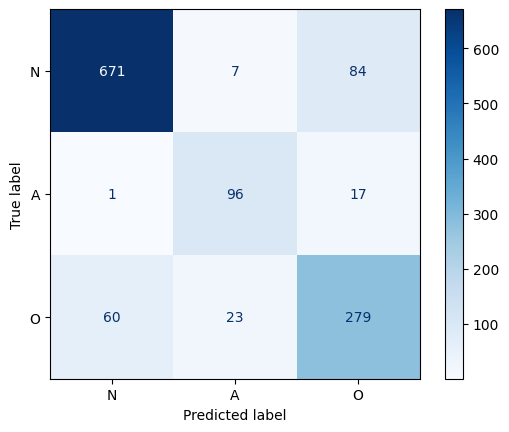

In [8]:
model = DenseNetGruEcgModule.load_from_checkpoint(checkpoint_callback.last_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"last_test_loss": test_loss.item()})
    wandb.log({"last_test_auprc": test_auprc.item()})
    wandb.log({"last_test_auroc": test_auroc.item()})
    wandb.log({"last_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"last_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"last_test_cm": test_cm_disp.figure_})

### Best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 21.33it/s]
test_loss: 0.5684822201728821
test_auprc: 0.8639323115348816
test_auroc: 0.9315894246101379
              precision    recall  f1-score   support

           N       0.90      0.88      0.89       762
           A       0.80      0.86      0.83       114
           O       0.73      0.76      0.74       362

    accuracy                           0.84      1238
   macro avg       0.81      0.83      0.82      1238
weighted avg       0.84      0.84      0.84      1238



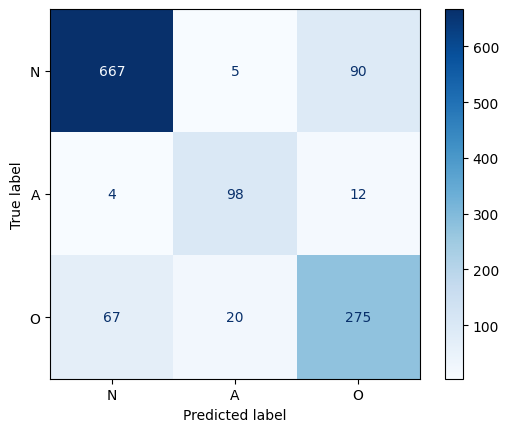

In [9]:
model = DenseNetGruEcgModule.load_from_checkpoint(checkpoint_callback.best_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"best_test_loss": test_loss.item()})
    wandb.log({"best_test_auprc": test_auprc.item()})
    wandb.log({"best_test_auroc": test_auroc.item()})
    wandb.log({"best_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"best_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"best_test_cm": test_cm_disp.figure_})

In [10]:
wandb.finish()

best_test_accuracy,▁
best_test_auprc,▁
best_test_auroc,▁
best_test_f1,▁
best_test_loss,▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
last_test_accuracy,▁
last_test_auprc,▁
last_test_auroc,▁
last_test_f1,▁
last_test_loss,▁
